In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import numpy as np  
import matplotlib.pyplot as plt

import cv2
import PIL

from tensorflow.keras import Model

In [3]:
vgg = tf.keras.applications.VGG19(include_top = True, weights = "imagenet")

vgg.save('VGG19.h5')

574726144/574710816 [==============================] - 3s 0us/step


In [4]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  gram_matrix = tf.expand_dims(result, axis=0)
  input_shape = tf.shape(input_tensor)
  i_j = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return gram_matrix/i_j 

In [12]:
def load_vgg():
  vgg = tf.keras.applications.VGG19(include_top=True, weights=None)
  vgg.load_weights('/content/drive/MyDrive/neural_style_transfer/vgg19_weights_tf_dim_ordering_tf_kernels.h5')
  vgg.trainable = False
  content_layers = ['block5_conv2']
  style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
  content_output = vgg.get_layer(content_layers[0]).output 
  style_output = [vgg.get_layer(style_layer).output for style_layer in style_layers]
  gram_style_output = [gram_matrix(output_) for output_ in style_output]

  model = Model([vgg.input], [content_output, gram_style_output])
  return model

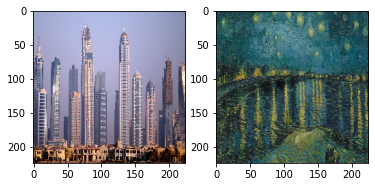

In [68]:
%matplotlib inline

content_image = cv2.resize(cv2.imread('/content/drive/MyDrive/neural_style_transfer/building.jpg'), (224, 224))
content_image = tf.image.convert_image_dtype(content_image, tf.float32)
style_image = cv2.resize(cv2.imread('/content/drive/MyDrive/neural_style_transfer/vangoghStyle.png'), (224, 224))
style_image = tf.image.convert_image_dtype(style_image, tf.float32)
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(np.array(content_image), cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(np.array(style_image), cv2.COLOR_BGR2RGB))
plt.show()

In [69]:
opt = tf.optimizers.Adam(learning_rate=0.005, beta_1=0.99, epsilon=1e-1)

In [70]:
def loss_object(style_outputs, content_outputs, style_target, content_target):
  style_weight = 1e-4
  content_weight = 1e-1
  content_loss = tf.reduce_mean((content_outputs - content_target)**2)
  style_loss = tf.add_n([tf.reduce_mean((output_ - target_)**2) for output_, target_ in zip(style_outputs, style_target)])
  total_loss = content_weight*content_loss + style_weight*style_loss
  return total_loss

In [71]:
vgg_model = load_vgg()
content_target = vgg_model(np.array([content_image*255]))[0]
style_target = vgg_model(np.array([style_image*255]))[1]

In [72]:
def train_step(image, epoch):
  with tf.GradientTape() as tape:
    output = vgg_model(image*255)
    loss = loss_object(output[1], output[0], style_target, content_target)
  gradient = tape.gradient(loss, image)
  opt.apply_gradients([(gradient, image)])
  image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0))

  if epoch % 5 ==0:
    tf.print(f"{epoch} Loss = {loss}")


In [73]:
EPOCHS = 10
STEPS = 100

image = tf.image.convert_image_dtype(content_image, tf.float32)
image = tf.Variable([image])
for i in range(EPOCHS):
  for m in range(STEPS):
    train_step(image, m)

0 Loss = 136163472.0
5 Loss = 36168556.0
10 Loss = 14463596.0
15 Loss = 9253601.0
20 Loss = 8072681.5
25 Loss = 7680902.5
30 Loss = 7145581.5
35 Loss = 6470465.5
40 Loss = 5810347.0
45 Loss = 5229942.0
50 Loss = 4763554.0
55 Loss = 4402380.5
60 Loss = 4113583.0
65 Loss = 3863841.5
70 Loss = 3644333.25
75 Loss = 3457846.5
80 Loss = 3294609.75
85 Loss = 3139373.5
90 Loss = 2985174.75
95 Loss = 2835905.0
0 Loss = 2695101.25
5 Loss = 2563707.75
10 Loss = 2441709.0
15 Loss = 2327140.0
20 Loss = 2218157.75
25 Loss = 2110627.5
30 Loss = 2006218.0
35 Loss = 1907632.625
40 Loss = 1816289.75
45 Loss = 1733349.75
50 Loss = 1656214.375
55 Loss = 1584330.25
60 Loss = 1516654.25
65 Loss = 1454026.5
70 Loss = 1395899.625
75 Loss = 1340844.625
80 Loss = 1288134.5
85 Loss = 1236785.25
90 Loss = 1187364.5
95 Loss = 1140861.375
0 Loss = 1097430.25
5 Loss = 1056652.25
10 Loss = 1017194.3125
15 Loss = 978553.6875
20 Loss = 941044.75
25 Loss = 905045.0625
30 Loss = 870757.1875
35 Loss = 838235.8125
40 Loss 

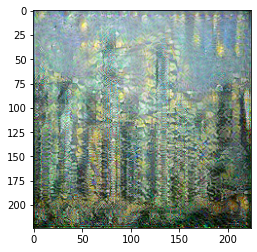

In [74]:
import PIL
tensor = image*255
tensor = np.array(tensor, dtype=np.uint8)
if np.ndim(tensor)>3:
  assert tensor.shape[0] == 1
  tensor = tensor[0]
tensor =  PIL.Image.fromarray(tensor)
plt.imshow(cv2.cvtColor(np.array(tensor), cv2.COLOR_BGR2RGB))
plt.show()